# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [0]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [0]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

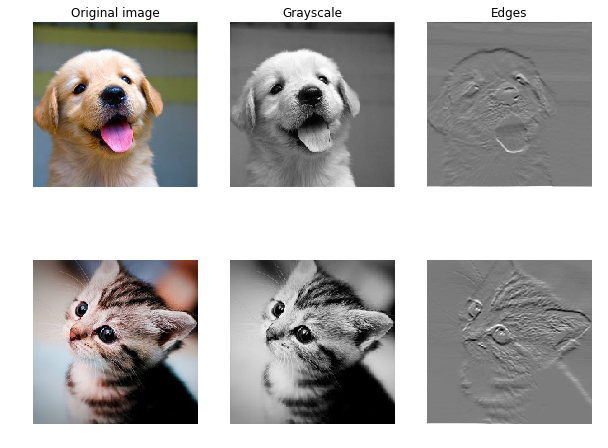

In [0]:
from imageio import imread
from PIL import Image

kitten = imread('notebook_images/kitten.jpg')
puppy = imread('notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [0]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [0]:
%%writefile cs231n/layers.py
from builtins import range
import numpy as np


def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    temp = x.reshape((len(x), -1))
    out = temp.dot(w) + b.reshape(1,len(b))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    temp = x.reshape((len(x), -1))
    db = dout.sum(axis = 0)
    dx = dout.dot(w.T).reshape(x.shape)
    dw = temp.T.dot(dout)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.clip(x, 0, None)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout*(x>0)
   
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        # 
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        mean = np.mean(x, axis = 0)
        var = np.var(x, axis = 0)
        std = np.sqrt(var+eps)
        temp = (x - mean)/std
        out = gamma*temp + beta
        
        running_mean = momentum*running_mean + (1 - momentum)*mean
        running_var = momentum*running_var + (1 - momentum)*var
        
        cache = {'x':x, 'gamma':gamma, 'mean':mean,
                 'std':std, 'u_out':temp, 'out':out}
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = gamma*(x - running_mean)/np.sqrt(running_var + eps) + beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    # Referencing the original paper (https://arxiv.org/abs/1502.03167)       #
    # might prove to be helpful.                                              #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = cache["x"]
    mean = cache["mean"]
    std = cache["std"] 
    u_out = cache["u_out"]
    gamma = cache["gamma"]
    N = len(x)
    
    dbeta  = dout.sum(axis = 0)
    dgamma = (u_out*dout).sum(axis = 0)
    
    du_out = gamma*dout
    dminus_2 = du_out/std
    dstd = ((x - mean)*du_out).sum(axis = 0)
    dminus_1 = -(x-mean)*dstd/(np.power(std,3)*N)
    dminus = dminus_1 + dminus_2
    dx = dminus - dminus.sum(0)/N
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """
    Alternative backward pass for batch normalization.

    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass. 
    See the jupyter notebook for more hints.
     
    Note: This implementation should expect to receive the same cache variable
    as batchnorm_backward, but might not use all of the values in the cache.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement; our implementation fits on a single 80-character line.#
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = cache["x"]
    mean = cache["mean"]
    std = cache["std"] 
    u_out = cache["u_out"]
    gamma = cache["gamma"]
    N = len(x)
    
    dbeta  = dout.sum(axis = 0)
    dgamma = (u_out*dout).sum(axis = 0)
    du_out = gamma*dout
    
    dx = du_out/std - du_out.sum(0)/(N*std) - np.sum(du_out*u_out/std, 0)*u_out/N 

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """
    Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point,
    before being scaled by gamma and beta parameters identical to that of batch normalization.
    
    Note that in contrast to batch normalization, the behavior during train and test-time for
    layer normalization are identical, and we do not need to keep track of running averages
    of any sort.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get('eps', 1e-5)
    ###########################################################################
    # TODO: Implement the training-time forward pass for layer norm.          #
    # Normalize the incoming data, and scale and  shift the normalized data   #
    #  using gamma and beta.                                                  #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of  batch normalization, and inserting a line or two of  #
    # well-placed code. In particular, can you think of any matrix            #
    # transformations you could perform, that would enable you to copy over   #
    # the batch norm code and leave it almost unchanged?                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    mean = x.mean(axis = 1)[..., None]
    var = x.var(axis = 1)[..., None]
    std = np.sqrt(var + eps)
    temp = (x-mean)/std 
    out = gamma*temp + beta
    
    cache = {'x':x, 'gamma':gamma, 'mean':mean,
                 'std':std, 'u_out':temp, 'out':out}

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache


def layernorm_backward(dout, cache):
    """
    Backward pass for layer normalization.

    For this implementation, you can heavily rely on the work you've done already
    for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for layer norm.                       #
    #                                                                         #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of batch normalization. The hints to the forward pass    #
    # still apply!                                                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = cache["x"]
    mean = cache["mean"]
    std = cache["std"] 
    u_out = cache["u_out"]
    gamma = cache["gamma"]
    _, D = x.shape
    
    dbeta  = dout.sum(axis = 0)
    dgamma = (u_out*dout).sum(axis = 0)
    du_out = gamma*dout
    
    dx = du_out/std - du_out.sum(1)[..., None]/(D*std) - np.sum(du_out*u_out/std, 1)[..., None]*u_out/D

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.

    NOTE: Please implement **inverted** dropout, not the vanilla version of dropout.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.

    NOTE 2: Keep in mind that p is the probability of **keep** a neuron
    output; this might be contrary to some sources, where it is referred to
    as the probability of dropping a neuron output.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                        #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        mask = (np.random.rand(*x.shape) < p)/p
        out = x * mask

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = x

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                            END OF YOUR CODE                         #
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dx = dout*mask

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    elif mode == 'test':
        dx = dout
    return dx


def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']
    H_ = 1 + (H + 2 * pad - HH) // stride
    W_ = 1 + (W + 2 * pad - WW) // stride
    out = np.zeros((N, F, H_, W_))
    x_padded = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), 'constant')
    
    for n in range(N):
      for f in range(F):
        for h in range(H_):
          for i in range(W_):
            out[n, f, h, i] = np.sum(x_padded[n, :, h*stride:h*stride+HH, i*stride:i*stride+WW] * w[f, ...]) + b[f]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b, conv_param)
    return out, cache


def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    (x, w, b, conv_param) = cache
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']
    H_ = 1 + (H + 2 * pad - HH) // stride
    W_ = 1 + (W + 2 * pad - WW) // stride
    x_padded = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), 'constant')
    
    dx_padded = np.zeros_like(x_padded)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)
    
    for n in range(N):
      for f in range(F):
        db[f] += np.sum(dout[n,f])
        for h in range(H_):
          for i in range(W_):
            dw[f] += dout[n, f, h, i]* x_padded[n, :, h*stride:h*stride+HH, i*stride:i*stride+WW]
            dx_padded[n, :, h*stride:h*stride+HH, i*stride:i*stride+WW] += w[f] * dout[n, f, h, i]
            
    dx = dx_padded[..., pad:pad+H, pad:pad+W]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions

    No padding is necessary here. Output size is given by 

    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the max-pooling forward pass                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = x.shape
    HH, WW, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
    H_ = 1 + (H - HH) // stride
    W_ = 1 + (W - WW) // stride
    
    out =np.zeros((N, C, H_, W_))
    for h in range(H_):
      for w in range(W_):
        out[..., h, w] = np.max(x[..., h*stride:h*stride+HH, w*stride: w*stride+WW], axis=(2,3))
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, pool_param)
    return out, cache


def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    ###########################################################################
    # TODO: Implement the max-pooling backward pass                           #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, pool_param = cache
    N, C, H_, W_ = dout.shape
    HH, WW, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
    
    dx = np.zeros_like(x)
    for n in range(N):
        for c in range(C):
            for h in range(H_):
                for w in range(W_):
                    ind = np.argmax(x[n, c, h*stride:h*stride+HH, w*stride:w*stride+WW])
                    ind_ = np.unravel_index(ind, (HH, WW))
                    dx[n, c, h*stride+ind_[0], w*stride+ind_[1]] = dout[n, c, h, w]

    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = x.shape
    x = x.transpose(0,2,3,1).reshape(N*H*W, C)
    out, cache = batchnorm_forward(x, gamma, beta, bn_param)
    out = out.reshape(N, H, W, C).transpose(0,3,1,2)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache


def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = dout.shape
    dout = dout.transpose(0,2,3,1).reshape(N*H*W, C)
    dx, dgamma, dbeta = batchnorm_backward_alt(dout, cache)
    dx = dx.reshape(N, H, W, C).transpose(0,3,1,2)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def spatial_groupnorm_forward(x, gamma, beta, G, gn_param):
    """
    Computes the forward pass for spatial group normalization.
    In contrast to layer normalization, group normalization splits each entry 
    in the data into G contiguous pieces, which it then normalizes independently.
    Per feature shifting and scaling are then applied to the data, in a manner identical to that of batch normalization and layer normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - G: Integer mumber of groups to split into, should be a divisor of C
    - gn_param: Dictionary with the following keys:
      - eps: Constant for numeric stability

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    eps = gn_param.get('eps',1e-5)
    ###########################################################################
    # TODO: Implement the forward pass for spatial group normalization.       #
    # This will be extremely similar to the layer norm implementation.        #
    # In particular, think about how you could transform the matrix so that   #
    # the bulk of the code is similar to both train-time batch normalization  #
    # and layer normalization!                                                # 
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = x.shape
    size = (N*G, C//G *H*W)
    temp = x.reshape(size).T
    mean = np.mean(temp, 0)
    var = np.var(temp, 0) + eps
    std = np.sqrt(var)
    temp = (temp - mean)/std
    temp = temp.T.reshape(N, C, H, W)
    out = gamma * temp + beta
    cache = {'x':x, 'gamma':gamma, 'mean':mean,
                 'std':std, 'u_out':temp, 'size':size}

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache


def spatial_groupnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial group normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial group normalization.      #
    # This will be extremely similar to the layer norm implementation.        #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = cache['x']
    mean = cache['mean']
    std = cache['std'] 
    u_out = cache['u_out']
    gamma = cache['gamma']
    size = cache['size']

    dbeta  = dout.sum(axis = (0,2,3), keepdims = True)
    dgamma = (u_out*dout).sum(axis = (0,2,3), keepdims = True)
    du_out = (gamma*dout).reshape(size).T
    u_out = u_out.reshape(size).T
    M = size[1]
    
    dx = du_out/std - du_out.sum(0)/(M*std) - np.sum(du_out*u_out/std, 0)*u_out/M 
    dx = dx.T.reshape(x.shape)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta


def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

Overwriting cs231n/layers.py


In [0]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [0]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [0]:
# Rel errors should be around e-9 or less
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 5.125996s
Fast: 0.013760s
Speedup: 372.532792x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 7.352439s
Fast: 0.012075s
Speedup: 608.912331x
dx difference:  1.949764775345631e-11
dw difference:  3.681156828004736e-13
db difference:  0.0


In [0]:
# Relative errors should be close to 0.0
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.012269s
fast: 0.002889s
speedup: 4.246575x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.429481s
fast: 0.013130s
speedup: 32.708859x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check they're working.

In [0]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802391137330214e-09
db error:  1.0146343411762047e-09


In [0]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [0]:
%pycat cs231n/classifiers/cnn.py

In [0]:
%%writefile cs231n/classifiers/cnn.py
from builtins import object
import numpy as np

from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.layer_utils import *


class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Width/height of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype

        ############################################################################
        # TODO: Initialize weights and biases for the three-layer convolutional    #
        # network. Weights should be initialized from a Gaussian centered at 0.0   #
        # with standard deviation equal to weight_scale; biases should be          #
        # initialized to zero. All weights and biases should be stored in the      #
        #  dictionary self.params. Store weights and biases for the convolutional  #
        # layer using the keys 'W1' and 'b1'; use keys 'W2' and 'b2' for the       #
        # weights and biases of the hidden affine layer, and keys 'W3' and 'b3'    #
        # for the weights and biases of the output affine layer.                   #
        #                                                                          #
        # IMPORTANT: For this assignment, you can assume that the padding          #
        # and stride of the first convolutional layer are chosen so that           #
        # **the width and height of the input are preserved**. Take a look at      #
        # the start of the loss() function to see how that happens.                #                           
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        C, H, W = input_dim
        H_ = 1 + (H - 2)//2
        W_ = 1 + (W - 2)//2
        self.params['W1'] = np.random.randn(num_filters, C, filter_size, filter_size) * weight_scale
        self.params['b1'] = np.zeros(num_filters)
        self.params['W2'] = np.random.randn(num_filters*H_*W_, hidden_dim) * weight_scale
        self.params['b2'] = np.zeros(hidden_dim)
        self.params['W3'] = np.random.randn(hidden_dim, num_classes) * weight_scale
        self.params['b3'] = np.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # Remember you can use the functions defined in cs231n/fast_layers.py and  #
        # cs231n/layer_utils.py in your implementation (already imported).         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        caches = {}
        out, caches['layer1'] = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
        out, caches['layer2'] = affine_relu_forward(out, W2, b2)
        scores, caches['layer3'] = affine_forward(out, W3, b3)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the three-layer convolutional net, #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dout = softmax_loss(scores, y)
        for i in [W1, W2, W3]:
          loss += 0.5*self.reg*np.sum(i*i)
          
        dout, grads['W3'], grads['b3'] = affine_backward(dout, caches['layer3'])
        dout, grads['W2'], grads['b2'] = affine_relu_backward(dout, caches['layer2'])
        dout, grads['W1'], grads['b1'] = conv_relu_pool_backward(dout, caches['layer1'])
        
        for i,w in enumerate([W1, W2, W3]):
          loss += 0.5*self.reg*np.sum(w*w)
          grads['W'+str(i+1)] += self.reg * w
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

Overwriting cs231n/classifiers/cnn.py


In [0]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302583314261004
Initial loss (with regularization):  2.7142104339008926


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [0]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [0]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

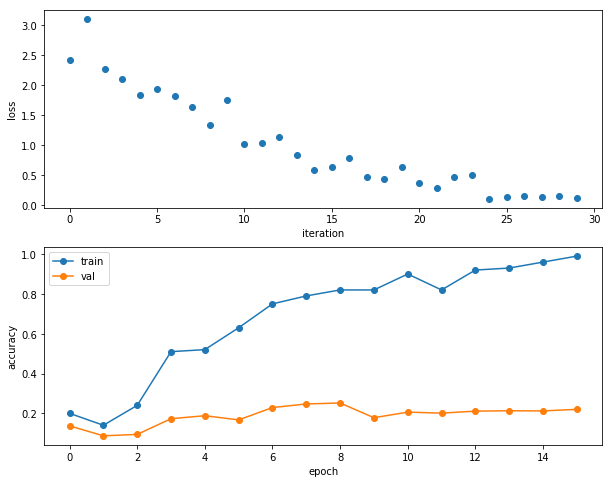

In [0]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [0]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.306791
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.130734
(Iteration 41 / 980) loss: 1.989418
(Iteration 61 / 980) loss: 1.930954
(Iteration 81 / 980) loss: 1.919418
(Iteration 101 / 980) loss: 1.892809
(Iteration 121 / 980) loss: 1.899278
(Iteration 141 / 980) loss: 1.839236
(Iteration 161 / 980) loss: 2.180614
(Iteration 181 / 980) loss: 1.866601
(Iteration 201 / 980) loss: 2.072020
(Iteration 221 / 980) loss: 2.054554
(Iteration 241 / 980) loss: 1.857157
(Iteration 261 / 980) loss: 1.725568
(Iteration 281 / 980) loss: 1.915450
(Iteration 301 / 980) loss: 1.831690
(Iteration 321 / 980) loss: 1.885989
(Iteration 341 / 980) loss: 1.749979
(Iteration 361 / 980) loss: 1.930959
(Iteration 381 / 980) loss: 1.353003
(Iteration 401 / 980) loss: 1.772421
(Iteration 421 / 980) loss: 1.523016
(Iteration 441 / 980) loss: 1.752534
(Iteration 461 / 980) loss: 1.782180
(Iteration 481 / 980) loss: 1.644777
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

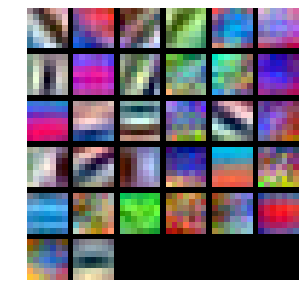

In [0]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. As proposed in the original paper (link in `BatchNormalization.ipynb`), batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [0]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [0]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [0]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648193872555e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


# Group Normalization
In the previous notebook, we mentioned that Layer Normalization is an alternative normalization technique that mitigates the batch size limitations of Batch Normalization. However, as the authors of [2] observed, Layer Normalization does not perform as well as Batch Normalization when used with Convolutional Layers:

>With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction, and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose
receptive fields lie near the boundary of the image are rarely turned on and thus have very different
statistics from the rest of the hidden units within the same layer.

The authors of [3] propose an intermediary technique. In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, they suggest a consistent splitting of each per-datapoint feature into G groups, and a per-group per-datapoint normalization instead. 

![Comparison of normalization techniques discussed so far](notebook_images/normalization.png)
<center>**Visual comparison of the normalization techniques discussed so far (image edited from [3])**</center>

Even though an assumption of equal contribution is still being made within each group, the authors hypothesize that this is not as problematic, as innate grouping arises within features for visual recognition. One example they use to illustrate this is that many high-performance handcrafted features in traditional Computer Vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [4]-- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

You will now implement Group Normalization. Note that this normalization technique that you are to implement in the following cells was introduced and published to ECCV just in 2018 -- this truly is still an ongoing and excitingly active field of research!

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)


[3] [Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)


[4] [N. Dalal and B. Triggs. Histograms of oriented gradients for
human detection. In Computer Vision and Pattern Recognition
(CVPR), 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)

## Group normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for group normalization in the function `spatial_groupnorm_forward`. Check your implementation by running the following:

In [0]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x_g.mean(axis=1))
print('  Stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out_g.mean(axis=1))
print('  Stds: ', out_g.std(axis=1))

Before spatial group normalization:
  Shape:  (2, 6, 4, 5)
  Means:  [9.72505327 8.51114185 8.9147544  9.43448077]
  Stds:  [3.67070958 3.09892597 4.27043622 3.97521327]
After spatial group normalization:
  Shape:  (2, 6, 4, 5)
  Means:  [-2.14643118e-16  5.25505565e-16  2.65528340e-16 -3.38618023e-16]
  Stds:  [0.99999963 0.99999948 0.99999973 0.99999968]


## Spatial group normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_groupnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [0]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)
#You should expect errors of magnitudes between 1e-12~1e-07
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  7.413109332145332e-08
dgamma error:  9.468195772749234e-12
dbeta error:  3.354494437653335e-12
